# Mean squared displacement

This notebook shows how to compute the mean squared displacement (MSD) and the rotation autocorrelation (MSAD) using the different algorithms available in [GEMDAT](https://gemdat.readthedocs.org).

One one side of the spectrum, the fastest way to obtain the MSD/MSAD is to use a single starting point, but this estimation is the most sensitive to fluctuations. The most statistically correct measure collects all the possible time windows of a given size, and it can be efficiently implemented using FFT. However it trades speed to achieve better precision. A good middle ground can be achieved by using $N$ starting points. 

In [1]:
import time
import numpy as np
from gemdat.utils import VASPRUN

# Use your own data:
# VASPRUN = 'path/to/your/vasprun.xml'

The entry point to GEMDAT is via a [Trajectory](https://gemdat.readthedocs.io/en/latest/api/gemdat_trajectory/#gemdat.trajectory.Trajectory). It is an extension of the [pymatgen Trajectory class](https://pymatgen.org/pymatgen.core.html#pymatgen.core.trajectory.Trajectory).

In [2]:
from gemdat import Trajectory

trajectory = Trajectory.from_vasprun(VASPRUN)

If we are interested in a single species, such as how Lithium diffuses through the system, we can filter it from the trajectory.
This creates a new Trajectory that only consists of Lithium.

In [3]:
diff_trajectory = trajectory.filter('Li')

Compute the MSD using FFT:

In [4]:
time_0 = time.time()
fft_msd = diff_trajectory.mean_squared_displacement(nstarts=-1)
time_fft = time.time()-time_0
print('The time for FFT-msd is', time_fft)

FFT method
The time for FFT-msd is 0.05368375778198242
(5000,)


Then compute the MSD in a direct way, processing multiple initial conditions in parallel using [numba](https://numba.pydata.org/)

In [5]:
nstarts_values = [1, 5, 10]
msd_results = []
time_results = []

for nstarts in nstarts_values:
    time_0 = time.time()
    nstarts_msd = diff_trajectory.mean_squared_displacement(nstarts=nstarts)
    # remove nans
    nstarts_msd = nstarts_msd[~np.isnan(nstarts_msd)]
    time_nstarts = time.time() - time_0
    print(f'The time for nstarts={nstarts} is', time_nstarts)
    msd_results.append(nstarts_msd)
    time_results.append(time_nstarts)

The time for nstarts=1 is 1.8784048557281494
(1,)
The time for nstarts=5 is 5.104005813598633
(4996,)
The time for nstarts=10 is 11.780820846557617
(4991,)


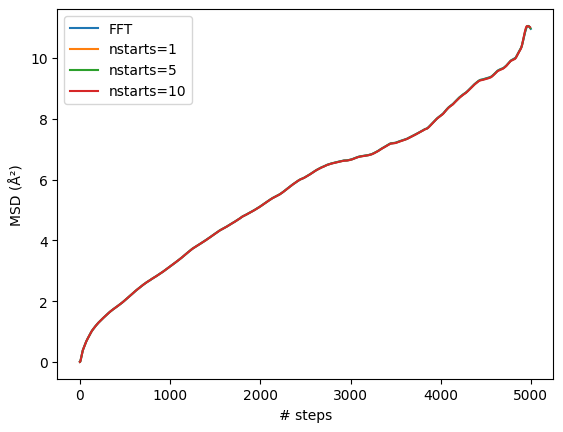

In [6]:
# Plot the results
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(fft_msd, label='FFT')
for nstarts, msd in zip(nstarts_values, msd_results):
    ax.plot(msd, label=f'nstarts={nstarts}')
ax.set_xlabel('# steps')
ax.set_ylabel('MSD (Å²)')
ax.legend()
plt.show()

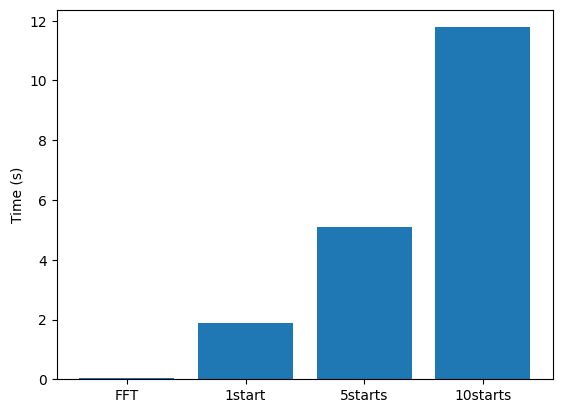

In [8]:
# Then we can compare the time
fig, ax = plt.subplots()
ax.bar(['FFT', '1start', '5starts', '10starts'], [time_fft, *time_results])
ax.set_ylabel('Time (s)')
plt.show()